In [48]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [49]:
BASE_DIR='/content/drive/MyDrive/flickr30k_images'
WORKING_DIR='/content/drive/MyDrive/flickr30k_work'

EXTRACT IMAGE FEATURES

In [4]:
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features={}
directory=os.path.join(BASE_DIR,'flickr30k_images')
for img_name in tqdm(os.listdir(directory)):
  img_path=directory+'/'+img_name
  image=load_img(img_path, target_size=(224,224))
  #convert image pixels to numpy array
  image=img_to_array(image)
  #reshape data for model
  image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  #preprocess image for vgg
  image=preprocess_input(image)
  #extract features
  feature=model.predict(image, verbose=0)
  #get image ID
  image_id=img_name.split('.')[0]
  #store feature
  features[image_id]=feature

In [ ]:
import os
import pickle
os.makedirs(WORKING_DIR,exist_ok=True)
with open(os.path.join(WORKING_DIR,'features.pkl'),'wb') as f:
  pickle.dump(features,f)

In [50]:
with open(os.path.join(BASE_DIR,'features.pkl'),'rb') as f:
  features=pickle.load(f)

In [51]:
import os
import pandas as pd

# BASE_DIR = "/mnt/data"
path = os.path.join(BASE_DIR, "results.csv")

# the regex '\s*\|\s*' will strip spaces around the pipe
df = pd.read_csv(path, sep=r"\s*\|\s*", engine="python")

# drop the “.jpg” and group by image
df["image_id"] = df["image_name"].str.replace(r"\.jpg$", "", regex=True)

# build your mapping in one line
mapping = df.groupby("image_id")["comment"].apply(list).to_dict()


In [52]:
len(mapping)

31783

In [53]:
import re

def clean_mapping(raw_mapping):
    """
    raw_mapping: dict(image_id → [raw captions…])
    Returns same structure with each caption:
      • lower‐cased
      • punctuation removed
      • collapsed spaces
      • one-letter words dropped
      • wrapped in "<start> … <end>" with real spaces
    """
    cleaned = {}
    for image_id, captions in raw_mapping.items():
        new_caps = []
        for cap in captions:
            # 1) skip None or non-strings
            if not isinstance(cap, str):
                continue

            # 2) lowercase
            cap = cap.lower()

            # 3) remove anything but a–z and spaces
            cap = re.sub(r'[^a-z\s]', '', cap)

            # 4) collapse runs of whitespace, trim
            cap = re.sub(r'\s+', ' ', cap).strip()
            if not cap:
                continue

            # 5) drop one-letter tokens
            tokens = [w for w in cap.split() if len(w) > 1]
            if not tokens:
                continue

            # 6) *this* is the key: put real spaces around your tags
            new_caption = "startseq " + " ".join(tokens) + " endseq"
            new_caps.append(new_caption)

        cleaned[image_id] = new_caps

    return cleaned

# usage
mapping = clean_mapping(mapping)


In [54]:
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [55]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [56]:
len(all_captions)

158914

In [57]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [14]:
import os
import pickle

# 1) Define your working directory
WORKING_DIR = "/content/drive/MyDrive/flickr30k_work"

# 2) Create it if it doesn’t exist
os.makedirs(WORKING_DIR, exist_ok=True)

# 3) Path to save the tokenizer
tokenizer_path = os.path.join(WORKING_DIR, "tokenizernew.pkl")

# 4) Serialize the fitted tokenizer
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

print(f"✅ Tokenizer saved to: {tokenizer_path}")


✅ Tokenizer saved to: /content/drive/MyDrive/flickr30k_work/tokenizernew.pkl


In [58]:
vocab_size

19750

In [59]:
max_length=max(len(caption.split()) for caption in all_captions)
max_length

74

In [60]:
## train Test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.99)
print(split)
train = image_ids[:split]
test = image_ids[split:]

31465


model creation

In [61]:
# after loading your features dict
sample_key = next(iter(features))
feat_dim   = features[sample_key].reshape(-1).shape[0]  # e.g. 512


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import os
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ── USER-SUPPLIED VARIABLES ───────────────────────────────────────────────────
# Ensure these are defined before running:
# tokenizer : a fitted keras.preprocessing.text.Tokenizer
# mapping   : dict mapping each key → list of caption strings
# features  : dict mapping each key → np.array of shape (1, D)
# train     : list of keys to include in training
# Checkpoints are saved as WORKING_DIR/model_{epoch}.h5

WORKING_DIR   = "/content/drive/MyDrive/flickr30k_work"
last_epoch    = 0
total_epochs  = 50
batch_size    = 32
max_length    = 34
vocab_size    = len(tokenizer.word_index) + 1
steps_per_ep  = len(train) // batch_size

# ── AUTO-DETECT FEATURE DIM ─────────────────────────────────────────────────────
feat_dim = features[train[0]].shape[1]
print("Detected feature dimension:", feat_dim)

# ── DATA GENERATOR ───────────────────────────────────────────────────────────────
def data_generator(keys, mapping, features,
                   tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    count = 0
    while True:
        for key in keys:
            for cap in mapping[key]:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    # POST-pad so masks are right-padded for CuDNN LSTM
                    in_seq  = pad_sequences([seq[:i]],
                                            maxlen=max_length,
                                            padding='post')[0]
                    out_seq = to_categorical([seq[i]],
                                             num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    count += 1
                    if count == batch_size:
                        # yield inputs as a tuple of tuples
                        yield ((np.array(X1, dtype=np.float32),
                                np.array(X2, dtype=np.int32)),
                               np.array(y,  dtype=np.float32))
                        X1, X2, y = [], [], []
                        count = 0

# ── BUILD MODEL ─────────────────────────────────────────────────────────────────
# Image‐feature branch
i1 = Input(shape=(feat_dim,), name="image_features")
x1 = Dropout(0.4)(i1)
x1 = Dense(256, activation="relu")(x1)

# Text branch
i2 = Input(shape=(max_length,), name="text_input")
x2 = Embedding(vocab_size, 256, mask_zero=True)(i2)
x2 = Dropout(0.4)(x2)
x2 = LSTM(256)(x2)  # CuDNN-compatible with post-padding

# Merge + output
m  = add([x1, x2])
m  = Dense(256, activation="relu")(m)
out = Dense(vocab_size, activation="softmax")(m)

model = Model([i1, i2], out, name="CaptionModel")
model.compile(optimizer=Adam(), loss="categorical_crossentropy")
model.summary()

#── LOAD WEIGHTS ────────────────────────────────────────────────────────────────
# weights_path = os.path.join(WORKING_DIR, f"model_{last_epoch}.h5")
# print("Loading weights from", weights_path)
# model.load_weights(weights_path)

# ── RESUME TRAINING ─────────────────────────────────────────────────────────────
for epoch in range(last_epoch+1, total_epochs):
    print(f"\n>>> Epoch {epoch}/{total_epochs-1}")
    gen = data_generator(
        train, mapping, features,
        tokenizer, max_length, vocab_size, batch_size
    )
    model.fit(
        gen,
        epochs=1,
        steps_per_epoch=steps_per_ep,
        verbose=1
    )
    out_path = os.path.join(WORKING_DIR, f"model_{epoch}.h5")
    model.save(out_path)
    print("Saved checkpoint:", out_path)


Detected feature dimension: 512


Model: "CaptionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  5,056,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 19750)     │  5,075,750 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,854,182 (41.41 MB)

 Trainable params: 10,854,182 (41.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
out_path = os.path.join(BASE_DIR, f"model_{epoch}.h5")
model.save(out_path)

In [62]:
# assume `train` is your list of keys
# and `features[key]` is an array of shape (1, D)
first_key = train[0]
feat_dim   = features[first_key].shape[1]
print("Detected feature dimension:", feat_dim)


Detected feature dimension: 512


In [63]:
#Generate captions for image
def idx_to_word(integer,tokenizer):
  for word, index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

In [19]:
def predict_caption(model,image,tokenizer,max_length):
  in_text='startseq'
  for i in range(max_length):
    sequence=tokenizer.text_to_sequences([in_text])[0]
    sequence=pad_sequences([sequence],maxlen=max_length)
    yhat=model.predict([image,sequence],verbose=0)
    yhat=np.argmax(yhat)
    word=idx_to_word(yhat,tokenizer)
    if word is None:
      break
    in_text+=" "+ word
    if word=='endseq':
      break
  return in_text

In [ ]:
import nltk

# Download the WordNet corpus and the Open Multilingual Wordnet (required by some versions)
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
## visualize the Results
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  image_id=image_name.split('.')[0]
  img_path=os.path.join(BASE_DIR,'flickr30k_images',image_name)
  image=Image.open(img_path)
  captions=mapping[image_name]
  print('---------------------Actual---------------------')
  for caption in captions:
    print(caption)
  y_pred=predict_caption(model,features[image_name],tokenizer,max_length)
  print('--------------------Predicted--------------------')
  print(y_pred)
  plt.imshow(image)


In [ ]:
def predict_caption(model, feature, tokenizer, max_length):
    in_text = 'startseq'             # use whatever start token you trained with
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')
        yhat = model.predict([feature, seq], verbose=0)
        idx  = np.argmax(yhat)
        word = tokenizer.index_word.get(idx)
        if word is None or word == 'endseq':  # match your end token
            break
        in_text += ' ' + word
    return in_text.replace('startseq ', '').replace(' endseq', '').strip()


In [ ]:
import heapq

def beam_search_predict(model, feature, tokenizer, max_length, beam_width=3):
    sequences = [("startseq", 0.0)]
    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            seq_ids = tokenizer.texts_to_sequences([seq])[0]
            pad     = pad_sequences([seq_ids], maxlen=max_length, padding='post')
            probs   = model.predict([feature, pad], verbose=0)[0]
            for idx in np.argsort(probs)[-beam_width:]:
                word = tokenizer.index_word.get(idx)
                if not word: continue
                candidate = (seq + " " + word, score - np.log(probs[idx] + 1e-9))
                all_candidates.append(candidate)
        # keep best k
        sequences = heapq.nsmallest(beam_width, all_candidates, key=lambda x: x[1])
    best_seq = sequences[0][0]
    return best_seq.replace("startseq ", "").split(" endseq")[0]


In [ ]:
def generate_caption(image_name):
    image_id = os.path.splitext(image_name)[0]
    feature  = features[image_id]

    # Greedy:
    caption = predict_caption(model, feature, tokenizer, max_length)

    # Or for debug:
    # caption = debug_predict(model, feature, tokenizer, max_length)

    # Or for beam-search:
    # caption = beam_search_predict(model, feature, tokenizer, max_length, beam_width=3)

    print("Generated caption:", caption)
    return caption


In [ ]:
generate_caption('81641.jpg')

Generated caption: pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped


'pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped pshaped'

In [ ]:
with open("/content/drive/MyDrive/flickr30k_images/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

BEAM SEARCH

In [ ]:
# 1) Imports & NLTK setup
import nltk
import numpy as np
from tqdm.notebook import tqdm
from nltk.translate.bleu_score  import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download METEOR resources (run once)
nltk.download('wordnet')
nltk.download('omw-1.4')

# 2) Beam‐search decoder (to boost BLEU)
def beam_search(feature, beam_width=3):
    sequences = [("startseq", 0.0)]
    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            seq_ids = tokenizer.texts_to_sequences([seq])[0]
            seq_pad = pad_sequences([seq_ids], maxlen=max_length, padding='post')
            probs   = model.predict([feature, seq_pad], verbose=0)[0]
            # expand each candidate
            for idx in np.argsort(probs)[-beam_width:]:
                word = tokenizer.index_word.get(idx)
                if not word:
                    continue
                cand_seq   = seq + " " + word
                cand_score = score - np.log(probs[idx] + 1e-9)
                all_candidates.append((cand_seq, cand_score))
        # select best beam_width sequences
        sequences = sorted(all_candidates, key=lambda t: t[1])[:beam_width]
    best = sequences[0][0]
    return best.replace("startseq ", "").split(" endseq")[0]

# 3) Evaluate on your test set
# assuming `test` is defined as:
# image_ids = list(mapping.keys())
# split = int(len(image_ids)*0.95)
# train = image_ids[:split]
# test  = image_ids[split:]

actual, predicted, meteor_scores = [], [], []

for img_id in tqdm(test, desc="Evaluating"):
    # 3a) References: list of token lists
    refs = [cap.split() for cap in mapping[img_id]]
    actual.append(refs)
    # 3b) Hypothesis via beam search
    feat = features[img_id]            # shape: (1, feat_dim)
    hyp  = beam_search(feat, beam_width=5)
    hyp_tokens = hyp.split()
    predicted.append(hyp_tokens)
    # 3c) Sentence‐level METEOR
    meteor_scores.append(meteor_score(refs, hyp_tokens))

# 4) Compute corpus‐level BLEU‐1, BLEU‐2 & average METEOR
bleu1      = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2      = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
avg_meteor = float(np.mean(meteor_scores))

print(f"BLEU-1 : {bleu1:.6f}")
print(f"BLEU-2 : {bleu2:.6f}")
print(f"METEOR : {avg_meteor:.6f}")


TEST FOR BEAM SEARCH

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers            import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam

# ── CONFIG ─────────────────────────────────────────────────────────────────────
WORKING_DIR  = "/content/drive/MyDrive/flickr30k_work"
WEIGHTS_FILE = os.path.join(WORKING_DIR, f"model_{last_epoch}.h5")  # replace last_epoch if needed

# ── BUILD MODEL ARCHITECTURE ───────────────────────────────────────────────────
feat_dim   = features[train[0]].shape[1]
vocab_size = len(tokenizer.word_index) + 1

# Image branch
i1 = Input(shape=(feat_dim,), name="image_features")
x1 = Dropout(0.4)(i1)
x1 = Dense(256, activation="relu")(x1)

# Text branch
i2 = Input(shape=(max_length,), name="text_input")
x2 = Embedding(vocab_size, 256, mask_zero=True)(i2)
x2 = Dropout(0.4)(x2)
x2 = LSTM(256)(x2)

# Merge & output
m   = add([x1, x2])
m   = Dense(256, activation="relu")(m)
out = Dense(vocab_size, activation="softmax")(m)

model = Model([i1, i2], out)
model.compile(optimizer=Adam(), loss="categorical_crossentropy")

# ── LOAD WEIGHTS ───────────────────────────────────────────────────────────────
print(f"Loading trained weights from {WEIGHTS_FILE}")
model.load_weights(WEIGHTS_FILE)

# ── GREEDY DECODE FUNCTION ─────────────────────────────────────────────────────
def predict_caption(feature):
    in_text = 'startseq'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')
        yhat = model.predict([feature, seq], verbose=0)[0]
        idx  = np.argmax(yhat)
        word = tokenizer.index_word.get(idx)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    # strip start/end tokens
    return in_text.replace('startseq ', '').replace(' endseq', '').strip()

# ── BEAM-SEARCH DECODE FUNCTION (optional) ─────────────────────────────────────
def beam_search(feature, beam_width=3):
    sequences = [("startseq", 0.0)]
    for _ in range(max_length):
        all_cand = []
        for seq, score in sequences:
            seq_ids = tokenizer.texts_to_sequences([seq])[0]
            seq_pad = pad_sequences([seq_ids], maxlen=max_length, padding='post')
            probs   = model.predict([feature, seq_pad], verbose=0)[0]
            for idx in np.argsort(probs)[-beam_width:]:
                word = tokenizer.index_word.get(idx)
                if not word: continue
                cand_seq   = seq + " " + word
                cand_score = score - np.log(probs[idx] + 1e-9)
                all_cand.append((cand_seq, cand_score))
        sequences = sorted(all_cand, key=lambda t: t[1])[:beam_width]
    best = sequences[0][0]
    return best.replace('startseq ', '').split(' endseq')[0]

# ── CAPTION GENERATION HELPER ──────────────────────────────────────────────────
def generate_caption_for_image(image_id, use_beam=False, beam_width=3):
    """
    Print the generated caption for a given image_id and show actual captions.
    """
    print(f"Image ID: {image_id}")
    # 1) Generate
    feat = features[image_id]  # shape (1, feat_dim)
    if use_beam:
        gen = beam_search(feat, beam_width=beam_width)
    else:
        gen = predict_caption(feat)
    print(" → Generated:", gen)
    # 2) Show references (if any)
    refs = mapping.get(image_id, [])
    if refs:
        print(" → Actual references:")
        for ref in refs:
            print("   -", ref.replace('startseq ', '').replace(' endseq', ''))
    else:
        print(" → No reference captions available.")

# ── EXAMPLE USAGE ──────────────────────────────────────────────────────────────
# Replace '1000092795' with any image_id in your features/mapping
generate_caption_for_image('1000092795', use_beam=True, beam_width=5)


Loading trained weights from /content/drive/MyDrive/flickr30k_work/model_49.h5
Image ID: 1000092795
 → Generated: two friends enjoy time spent together
 → Actual references:
   - two young guys with shaggy hair look at their hands while hanging out in the yard
   - two young white males are outside near many bushes
   - two men in green shirts are standing in yard
   - man in blue shirt standing in garden
   - two friends enjoy time spent together


In [43]:
TOKENIZER_PATH="/content/drive/MyDrive/flickr30k_work/tokenizernew.pkl"
with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

Actual captions:
 • two young guys with shaggy hair look at their hands while hanging out in the yard
 • two young white males are outside near many bushes
 • two men in green shirts are standing in yard
 • man in blue shirt standing in garden
 • two friends enjoy time spent together

Generated caption:
 → two friends enjoy outside in the yard


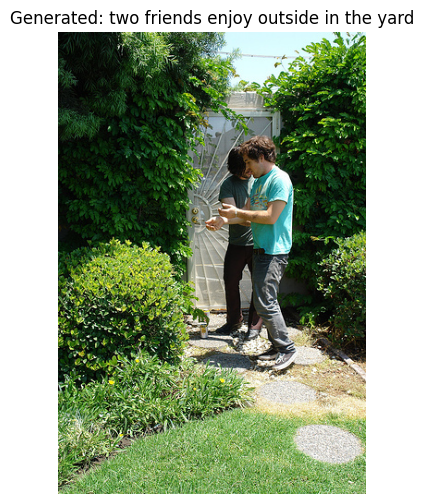

Actual captions:
 • two young guys with shaggy hair look at their hands while hanging out in the yard
 • two young white males are outside near many bushes
 • two men in green shirts are standing in yard
 • man in blue shirt standing in garden
 • two friends enjoy time spent together

Generated caption:
 → two friends enjoy time spent together


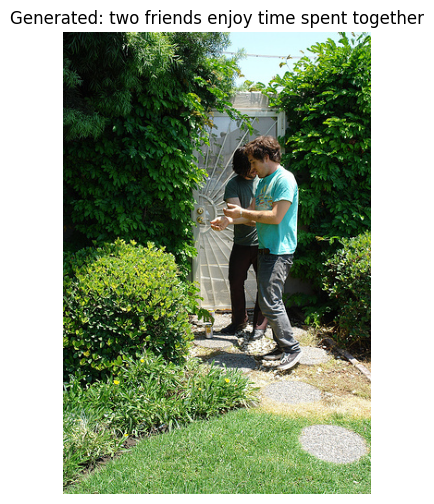

In [66]:
import os
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import matplotlib.pyplot as plt
IMG_DIR="/content/drive/MyDrive/flickr30k_images/flickr30k_images"
# ── Make sure these are in scope ────────────────────────────────────────────────
#   • model        : your trained Model
#   • tokenizer    : the fitted Tokenizer
#   • mapping      : dict image_id → list of "startseq ... endseq" captions
#   • features     : dict image_id → np.array(shape=(1,feat_dim))
#   • max_length   : the max caption length integer
#   • IMG_DIR      : path to your flickr30k_images folder

# ── GREEDY PREDICT ──────────────────────────────────────────────────────────────
def predict_caption(model, feature, tokenizer, max_length):
    in_text = "startseq"
    for _ in range(max_length):
        # convert current text to sequence and pad
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding="post")
        # predict next word
        yhat = model.predict([feature, seq], verbose=0)[0]
        idx  = np.argmax(yhat)
        word = tokenizer.index_word.get(idx)
        if word is None or word == "endseq":
            break
        in_text += " " + word
    # strip off the start token
    return in_text.replace("startseq ", "").strip()

# ── VISUALIZE IMAGE + CAPTIONS ─────────────────────────────────────────────────
def show_image_and_caption(image_name, use_beam=False, beam_width=3):
    """
    Displays the image, prints ground-truth captions,
    and prints the generated caption (greedy or beam-search).
    """
    # 1) Derive the key without extension
    image_id = os.path.splitext(image_name)[0]

    # 2) Load & show the image
    img_path = os.path.join(IMG_DIR, image_name)
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")

    # 3) Print actual captions
    print("Actual captions:")
    for cap in mapping.get(image_id, []):
        print(" •", cap.replace("startseq ", "").replace(" endseq", ""))

    # 4) Generate
    feat = features[image_id]  # shape (1, feat_dim)
    if use_beam:
        gen = beam_search(feat, beam_width)  # if you have beam_search
    else:
        gen = predict_caption(model, feat, tokenizer, max_length)

    # 5) Show generated caption
    print("\nGenerated caption:")
    print(" →", gen)
    plt.title(f"Generated: {gen}", wrap=True)
    plt.show()

# ── USAGE ──────────────────────────────────────────────────────────────────────
# Make sure IMG_DIR is set:
# IMG_DIR = "/content/drive/MyDrive/flickr30k_images"

# Then, for example:
show_image_and_caption("1000092795.jpg", use_beam=False)
# or with beam search:
show_image_and_caption("1000092795.jpg", use_beam=True, beam_width=5)


BLEU FOR GREEDY SEARCH

In [ ]:
# 1) Imports & NLTK setup
import nltk
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score  import corpus_bleu
from nltk.translate.meteor_score import meteor_score

# Download METEOR resources (once)
nltk.download('wordnet')
nltk.download('omw-1.4')

# 2) Prepare containers
actual, predicted, meteor_scores = [], [], []

# 3) Loop over your test split
#    Assumes you have defined:
#      • test       : list of image_id strings
#      • mapping    : dict image_id → list of "startseq ... endseq" captions
#      • features   : dict image_id → np.array of shape (1, feat_dim)
#      • model      : your trained caption model
#      • tokenizer  : your fitted Tokenizer
#      • max_length : maximum caption length integer
#      • predict_caption(...)  or beam_search(...)

for img_id in tqdm(test, desc="Evaluating"):
    # a) References: list of tokenized captions
    refs = [cap.replace("startseq ", "").replace(" endseq", "").split()
            for cap in mapping[img_id]]
    actual.append(refs)

    # b) Hypothesis: greedy or beam-search
    feat = features[img_id]  # (1, feat_dim)
    # choose one:
    hyp_text = predict_caption(model, feat, tokenizer, max_length)
    #hyp_text = beam_search(feat, beam_width=5)

    hyp_tokens = hyp_text.split()
    predicted.append(hyp_tokens)

    # c) Sentence‐level METEOR
    meteor_scores.append(meteor_score(refs, hyp_tokens))

# 4) Compute corpus‐level BLEU‐1, BLEU‐2 and average METEOR
bleu1      = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2      = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
avg_meteor = np.mean(meteor_scores)

# 5) Display results
print(f"BLEU-1 : {bleu1:.6f}")
print(f"BLEU-2 : {bleu2:.6f}")
print(f"METEOR : {avg_meteor:.6f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating: 100%|██████████| 318/318 [12:49<00:00,  2.42s/it]


BLEU-1 : 0.318691
BLEU-2 : 0.135079
METEOR : 0.162146


BLEU FOR BEAM SEARCH

In [67]:
# 1) Imports & NLTK setup
import nltk
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score  import corpus_bleu
from nltk.translate.meteor_score import meteor_score

# Download METEOR resources (once)
nltk.download('wordnet')
nltk.download('omw-1.4')

# 2) Prepare containers
actual, predicted, meteor_scores = [], [], []

# 3) Loop over your test split
#    Assumes you have defined:
#      • test       : list of image_id strings
#      • mapping    : dict image_id → list of "startseq ... endseq" captions
#      • features   : dict image_id → np.array of shape (1, feat_dim)
#      • model      : your trained caption model
#      • tokenizer  : your fitted Tokenizer
#      • max_length : maximum caption length integer
#      • predict_caption(...)  or beam_search(...)

for img_id in tqdm(test, desc="Evaluating"):
    # a) References: list of tokenized captions
    refs = [cap.replace("startseq ", "").replace(" endseq", "").split()
            for cap in mapping[img_id]]
    actual.append(refs)

    # b) Hypothesis: greedy or beam-search
    feat = features[img_id]  # (1, feat_dim)
    # choose one:
    #hyp_text = predict_caption(model, feat, tokenizer, max_length)
    hyp_text = beam_search(feat, beam_width=5)

    hyp_tokens = hyp_text.split()
    predicted.append(hyp_tokens)

    # c) Sentence‐level METEOR
    meteor_scores.append(meteor_score(refs, hyp_tokens))

# 4) Compute corpus‐level BLEU‐1, BLEU‐2 and average METEOR
bleu1      = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2      = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
avg_meteor = np.mean(meteor_scores)

# 5) Display results
print(f"BLEU-1 : {bleu1:.6f}")
print(f"BLEU-2 : {bleu2:.6f}")
print(f"METEOR : {avg_meteor:.6f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating: 100%|██████████| 318/318 [4:53:50<00:00, 55.44s/it]

BLEU-1 : 0.287565
BLEU-2 : 0.125203
METEOR : 0.151841
